## Project and Data

This project involved utilizing a GAN in order to take real photos and change them into the style of a Monet painting. A generative adversarial network (GAN) utilizes a generator and a discriminator. The generator creates photos and the discriminator is then used to judge how well the generated images perform according to some loss function. Then, the generator updates its weights to better itself against the discriminator, while the discriminator also updates its weights to better discriminate against the generator. Thus, in this 'adversarial' way the model improves itself by continuously updating its weighs for its generator to improve against the discriminate and generate images in accordance with some purpose.

In our case, we are generating photos in the style of Monet. The data for this project involved photos of Monet paintings as well as various photographs of everyday objects. The data were provided in two formats. One was in a folder of jpg format and contained 300 photos and 7038 photos. Further, there was a provided format in the form of TFRecords. TFRecords are a storage system and which stores data as set of sequences of binary strings. This type of storage helps in terms of computational memory and performance. This is a specialized storage system which is optimized for TensorFlow. Of these TFRecords, the Monet files, have a length of 5 when read in and a length of 20. Thus, we can already see how the data scale of the data is already reduced by using TFRecords here. This data was loaded into my notebook through tf.io.gfile.glob. 

In [173]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate
from keras.layers import ZeroPadding2D

In [174]:
#importing the photos as files according to tutorial kaggle recommends to use
#gets each file from monet and photo tfrec folder

# #for kaggle notebook
# from kaggle_datasets import KaggleDatasets
# path = KaggleDatasets().get_gcs_path()
# monet_files = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
# photo_files = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))

#for local running
monet_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/photo_tfrec/*.tfrec')
print('Monet length: ', len(monet_files))
print('Photo length: ', len(photo_files))

Monet length:  5
Photo length:  20


## Data Preprocessing and Limited EDA

This was my first time working with TFRecords and thus, I utilized TensorFlow documentation on the process of reading in the data as well as a notebook suggested by Kaggle to work on this project. Both sources are listed at the bottom of this page. However, the preprocessing of the data began by setting the format with an image and image name of the TFRecords. Then, with this format, I created a function with python methods to convert data from TFRecord into photo data of size (256, 256, 3). This is done by parsing each example of the TFRecord according to the defined format. Then, it is decoded with 3 channels for RGB photos. Then, it is cast into numeric pixel versions and normalized from a scale to [1, 1]. Next, the images are reshaped into (256, 256, 3) as the initial pictures are of pixel size (256, 256) and as mentioned, we are using a RGB color scale. Lastly, I randomly flipped images in each dataset in efforts to improve model performance. With this function, the data were then loaded into a tf dataset for each batch of Monets and photos.

Next, I wanted to view the first photo in each dataset. This was performed with a function which converts each pixel value onto a scale [0,1] and then utilizes pyplot to show each image.  

In [175]:
#setting the formats, for the parser to get into tf dataset
formats = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}
def tfrecord_img(instance):
    #parsing the single instance with proper format
    img_examp = tf.io.parse_single_example(instance, formats)
    img = img_examp['image']
    #decoding the image to show it is a rgb color scheme
    img_decode = tf.image.decode_jpeg(img, channels = 3)
    #casting the image pixels to float 32 and normalizing to [-1, 1]
    img_cast = (tf.cast(img_decode, tf.float32) / 127.5) - 1
    #reshaping to (256, 256, 3) for 256 256 size and 3 for channel
    img_reshape = tf.reshape(img_cast, [*[256, 256], 3])
    #randomly flipping images across the y-axis
    img_final = tf.image.random_flip_left_right(img_reshape)
    return img_final
    

#loading the data from the monet tfrec folder into a tf dataset with the applied tfrecord format
#also batching the values with a size of 1
monet_dataset = tf.data.TFRecordDataset(monet_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)
#performing the same mechanism to photos tfrec folder
photo_dataset = tf.data.TFRecordDataset(photo_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)


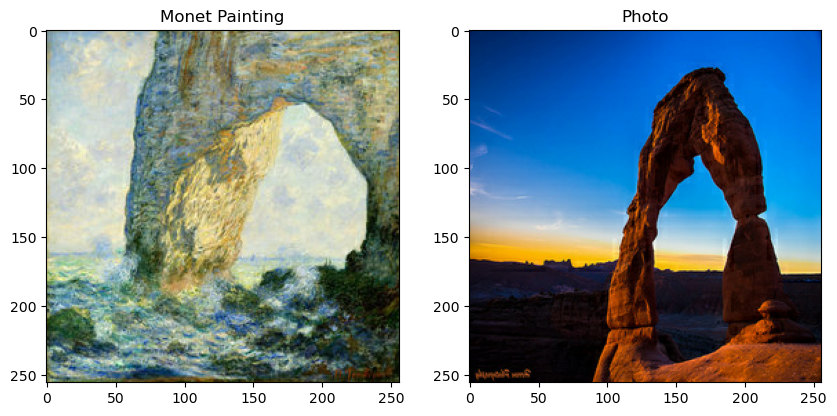

In [176]:
##printing the pictures of monet and photos

#getting the first image in both monet and photo datasets for viewing
monet_single = next((iter(monet_dataset)))
photo_single = next(iter(photo_dataset))


#plotting with plt
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 10))
#showing the first monet picture, changing pixel size [0, 1] to visualize
ax.imshow(monet_single[0] * 0.5 + .5)
ax.title.set_text('Monet Painting')
#applying same treatment to first photo
ax1.imshow(photo_single[0] * 0.5 + .5)
ax1.title.set_text('Photo')

## Functions for Modeling

Here, I am defining my functions which will be called in the model itself. First off, in the encoder (or downsampler), we are applying a keras sequential model with a to-be defined filters and size and whether to batch normalize (improving model speed). In this model, we have a convolution layer, followed by a batchnormalizer layer if argument is true, and finally we use a leaky relu layer. Then, we define our decoder (upsampler) which will be used to decode the encoded images in the GAN methodology. For the encoder we again take arguments for number of filters, the size, and here we instead take argument on whether to apply dropout layer (to improve model performance). Here; however, we start with a Convolution transpose layer. Convolution transpose layers are the opposite of convolution layers, which makes sense, since we are decoding the convolution layer of the encoder. Further, we are batch normalizing on every iteration here, and if dropout is applied, I add a dropout rate of 0.7 to improve model speed. Finally, a Relu layer is added. 


In [177]:
#https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

#encoder(downsampler)
def encoder(filters, size, apply_batchnorm=True):
    #utilizing a random normal initializer for kernel initializer in model 
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding convolution layer with stride and filters and size to be provided at later time
    model.add(Conv2D(filters, size,
                    strides=2, padding='same',
                    kernel_initializer=initializer, use_bias = False))
    #choosing when to apply batchnormalization (to improve model performance between conv and lrelu)
    if apply_batchnorm:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model
    
    
#decoder (upsampler)
def decoder(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding conv2d transpose layer (opposite of last conv) to decode back to normal
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())
    #adding dropout layers for certain layers when provided to improve model performance
    if apply_dropout:
        model.add(Dropout(0.7))
    model.add(ReLU())
    return model


## Functions for Modeling Continued (Generator)

Once we have our encoders and decoders defined, we can begin to build a generator. We begin by setting an input layer which will be set for the image size of (256, 256, 3). Then, we will apply a collection of our encoder functions. In sum, we will have eight encoders. The number of filters I chose to use for my first model were:
[64, 128, 128, 128, 128, 256, 256, 256] and I batch normalized all but the first encoder. These were lower than the majority number of filters I saw utilized in the majority of example generators I used. However, I wanted to start here to see how it performed and how it would operate on my personal machine. Then, I set the decoders to use to be 7 decoders and a final Conv2d Transpose layer. The filters chosen for the decoders were [256, 256, 256, 256, 128, 128, 64] and the final layer having 3 filters corresponding to 3 color channels with a tanh activation function. The way the generator operates is it takes an image and it puts it through all of the encoders and then puts it through all of the decoders and eventually returns the entire model in order to be called in the cycle GAN. I visualize the generator function below the function.

In [178]:
#generator for the data which utilizes encoders and decoders
def Generator():
    #input layer which has images of size (256, 256, 3) due to rgb
    inputs = Input(shape=[256, 256, 3])
    #encoding the input layer by calling encoder function set times with #filters and size
    encoders = [
        encoder(64, 4, apply_batchnorm=False),
        encoder(128, 4),
        encoder(128, 4),
        encoder(128, 4),
        encoder(128, 4),
        encoder(256, 4),
        encoder(256, 4),
        encoder(256, 4)
    ]
    #decoding the output from the encoders calling decoder function with #filters and size
    decoders = [
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4),
        decoder(128, 4),
        decoder(128, 4),
        decoder(64, 4)
    ]
    initializer = tf.random_normal_initializer(0, 0.02)
    #final layer of decoder which adds conv2d with 3 fitlers and tanh to get back to proper channels
    ##we see we have same number of encoder layers as decoder layers
    final = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer=initializer,
                          activation = 'tanh')
    #taking each input and running it through each encoder instances
    vals = inputs
    skips = []
    for down in encoders:
        vals = down(vals)
        skips.append(vals)
    #reversing and going through decoders
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoders, skips):
        vals = up(vals)
        vals = Concatenate()([vals, skip])
    vals = final(vals)
    #thus, runs through eno
    return tf.keras.Model(inputs=inputs, outputs=vals)

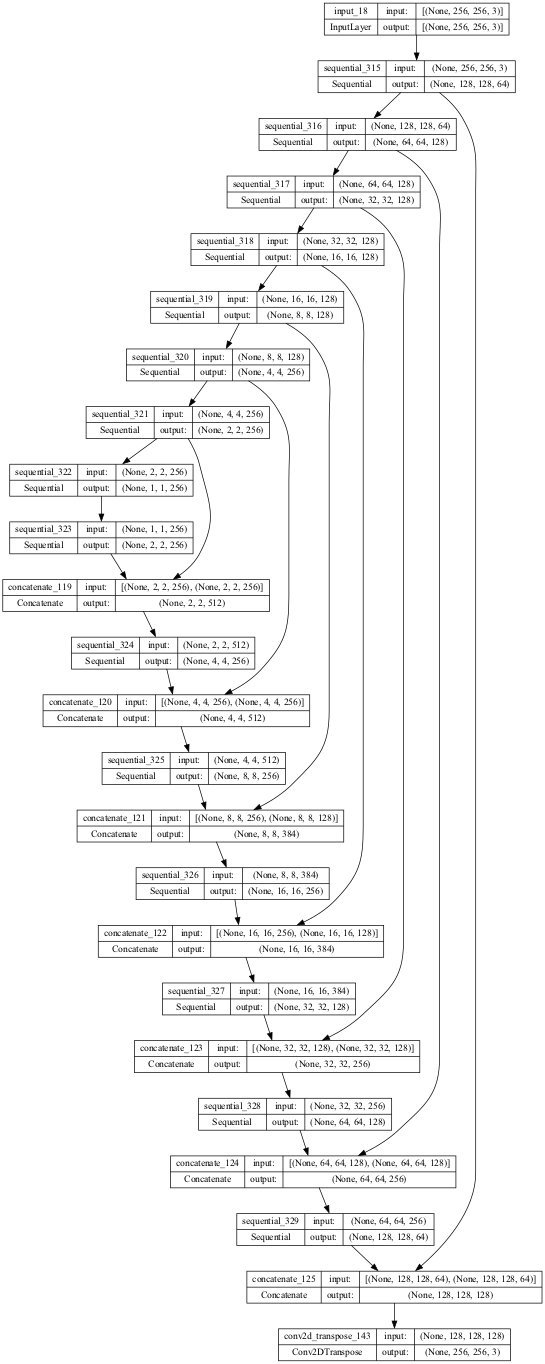

In [179]:
#visualizes the generation process of encoding and decoding
tf.keras.utils.plot_model(Generator(), show_shapes=True, dpi=50)

## Functions for Modeling (Discriminator)
Next, we define the discriminator. Here we again have an input layer of image shape (256, 256, 3). We then take that image and run it through 3 encoders. In my first model, I utilized 64, 128, and 256 filters for these. After th encoders, I added a zero padding layer to help preserve  image size. Then, I placed it through a convolution layer with 512 filters, a batch normalization layer, a leaky_relu, another zero padding, and a final convolution layer. Again the function ends by returning all of its operations as a model to be called within the cycle GAN. Further, I visualize the operations of the model below the function definition.

After this, I set a specific generator and discriminator for both Monet and photos. Lastly I set each Monet and photo generation and discrimination to have its own optimizer. The optimizer utilized was an Adam operator with a learning rate of 0.002 and a beta_1 of 0.5, based upon observation of similar models in Tensorflow documentation and Kaggle code. 

In [180]:
#discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    #initial input to discriminators
    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    vals = inputs
    #running through 3 encoders, building upon last encoding
    encode_1 = encoder(64, 4, False)(vals)  
    encode_2 = encoder(128, 4)(encode_1)  
    encode_3 = encoder(256, 4)(encode_2) 
    #padding with zeros to encoded data
    zero_pad_1 = ZeroPadding2D()(encode_3) 
    #conv layer
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad_1) 

    batchnorm_1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm_1)
    #padding again
    zero_pad_2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    #final convolution layer
    final = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad_2)  # (batch_size, 30, 30, 1)
    #returing discriminator as model
    return tf.keras.Model(inputs=vals, outputs=final)


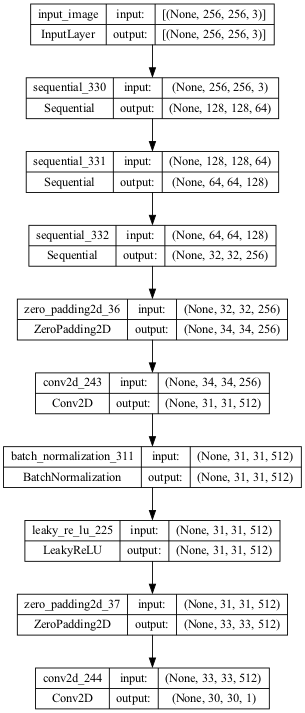

In [181]:
#visualizing discriminator 
tf.keras.utils.plot_model(Discriminator(), show_shapes=True, dpi=64)

In [182]:
#setting generator and discriminator for monet and photo
#applying generator and discriminators for each photo and monet
generate_monet = Generator()
generate_photo = Generator()
discriminate_monet = Discriminator()
discriminate_photo = Discriminator()

#using adam as optimizer with learning rate 0.0002 and beta of 0.5
#utilizing legacy version of Adam as due to my tf version, legacy optimizer is needed to run
adam = tf.keras.optimizers.legacy.Adam(0.0002, beta_1=0.5)
#setting optimizers for each generation and discrimination of monet and photo
generate_monet_opt = adam
generate_photo_opt = adam
discriminate_monet_opt = adam
discriminate_photo_opt = adam

## Additional Function

In this generate images function I wanted to show what the initial generation looks like for both photos to Monet and Monet to photos. This was by showing each image side by side through pyplot after running through generation for Monet and photos for initial photo and Monet from dataset.


In [183]:
#show what initial iteration of generating from monet and photo looks like
def generate_images(model, test_input):
    #getting predicted image from provided input
    prediction = model(test_input, training=True)
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(display_list[0] * 0.5 + 0.5)
    ax2.imshow(display_list[1] * 0.5 + 0.5)
    ax1.title.set_text(title[0])
    ax2.title.set_text(title[1])
    plt.show()

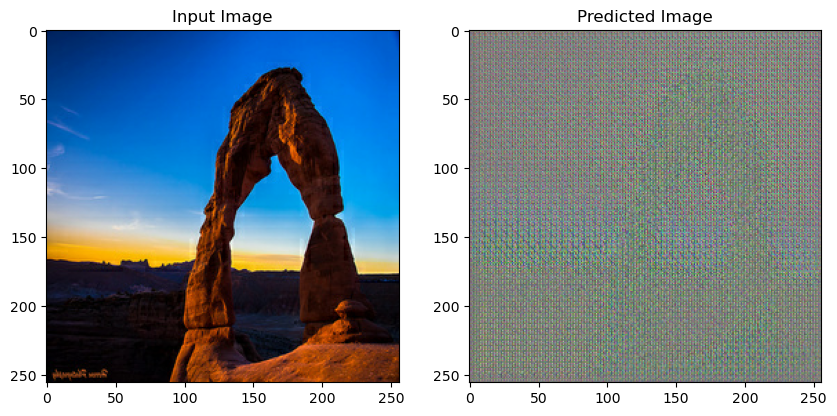

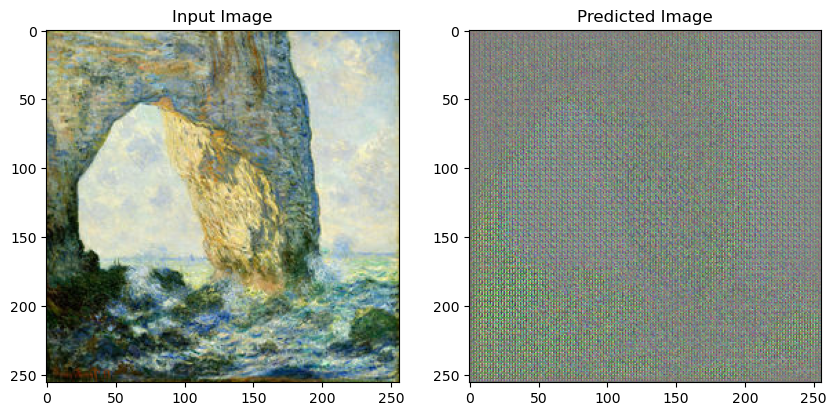

In [184]:
#generate monet from photo
for example_input in photo_dataset.take(1):
    generate_images(generate_monet, example_input)
#generate photo from monet
for example_input in monet_dataset.take(1):
    generate_images(generate_photo, example_input)

## Loss Functions for Modeling

After defining generators and discriminators, we need to define our loss functions so that model can update its weights and improve itself depending upon loss. First, I created a discriminator loss function which takes as input a real image and a generated image. It then looks at binary cross entropy for both the real image and the generated image. These losses are then added and multiplied by 0.5 and returned. 

Next, for the generator loss, we take binary cross entropy and apply it to the generated image itself. Then, we define a cycle loss which helps improve model consistency. This is done by looking at a cycled image which will generate a Monet from the generated photo and generate a photo from the generated Monet. The cycle loss then measures the loss between the real image whether it be Monet or photo and measures it against the cycle photo or Monet. In this way, we have an additional measure to see how generated images perform against each other by generating from them.

Lastly, we have an identity loss function. This generates a Monet or photo from a Monet or photo respectively. It then measures the loss between the generated image and the input image. Again, we get further loss metrics on how generation is occurring which will help the model fine-tune its weights. 

In [185]:
#building loss function for our discriminator
def discriminator_loss(real_image, generated_image):
    #using binary cross entropy as mentioned in lecture
    #loss looking at real images
    loss_for_real = tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(real_image), real_image)
    #loss looking at generated images
    loss_for_generated = tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.zeros_like(generated_image), generated_image)
    total_loss_for_discriminator = loss_for_generated + loss_for_real
    return total_loss_for_discriminator * 0.5
#building loss function for generator
def generator_loss(generated_image):
    return tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(generated_image), generated_image)

#utilizing cycle consistency, put this in write up
def cycle_loss(real_image, cycled_image):
    #getting los between real images and cycle image
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss

#utilizing identity loss, put in write up
def identity_loss(real_image, same_real_image):
    #loss of real image and the generation to appear as same as this image
    loss = tf.reduce_mean(tf.abs(real_image - same_real_image))
    return 10 * loss * 0.5

## The Model

We then build our cycle GAN, largely based upon the defined Cycle GAN's in the keras documentation and the provided notebook by Kaggle. We begin by utilizing the CycleGan class which we set as a keras Model. The class takes as arguments the generators and discriminators defined above and sets them as properties of the class. Then we create a compilation method which takes as input, the optimizers and loss functions defined above. Again, these are set as properties of the class. 

Next, we define a train_step method for the class which takes as input the input data which will be a tuple of a Monet and a photo. In our function we use a GradientTape in accordance with Tensorflow documentation on GANs. We then, generate a Monet, a photo (these from the generators for opposite images), a cycled Monet and photo, and then an identity Monet and photo. We then call our discriminators on the inputted Monet and photo as well as the generated Monet and photo. Once we have called generators and discriminators, we apply each as inputs to our loss functions accordingly for each function. These outputs from the loss functions are then totaled to receive a total loss for generation and discrimination. 

Next, and outside the GenerationTape (again in accordance with Tensorflow documentation) we set the gradients for both generators and discriminators for Monet and photo each. The optimizers properties of the class then get these gradients applied to them to update the optimizer. Lastly, the loss results of generators and discriminators are returned.

After the model creation, the model is called, compiled, and then fitted on the datasets. I initially utilized 10 epochs in my first model iteration. This model received a score of 684.06252 on the Kaggle competition.

In [186]:
#building the cycle gan from defined functions above
class CycleGan(tf.keras.Model):
    #defining what arguments model will accept, here taking generators and discriminators
    def __init__(
        self,
        generate_monet,
        generate_photo,
        discriminate_monet,
        discriminate_photo
    ):
        #followed operations from #https://keras.io/examples/generative/cyclegan/ here
        super(CycleGan, self).__init__()
        #setting each generator and discriminator to be used throughout class
        self.generate_monet = generate_monet
        self.generate_photo = generate_photo
        self.discriminate_monet = discriminate_monet
        self.discriminate_photo = discriminate_photo
    #compiling the model and selecting input of optimizers and loss functions
    def compile(self,
        generate_monet_opt,
        generate_photo_opt,
        discriminate_monet_opt,
        discriminate_photo_opt,
        geneator_loss,
        discriminator_loss,
        cycle_loss,
        idnetity_loss
        
    ):
        super(CycleGan, self).compile()
        #setting optimizers and loss functions to be used for later instances in class
        self.model_generate_monet_opt = generate_monet_opt
        self.model_generate_photo_opt = generate_photo_opt
        self.model_discriminate_monet_opt = discriminate_monet_opt
        self.model_discriminate_photo_opt = discriminate_photo_opt
        self.model_generator_loss = generator_loss
        self.model_discriminator_loss = discriminator_loss
        self.model_cycle_loss = cycle_loss
        self.model_identity_loss = identity_loss
        
    
    #function that trains model  
    def train_step(self, input_data):
        #getting monet and photo which will be provided to model
        real_monet, real_photo = input_data
        #using GradientTape in accordance with https://www.tensorflow.org/tutorials/generative/cyclegan
        with tf.GradientTape(persistent=True) as tape:
            #generating monet from photo
            fake_monet = self.generate_monet(real_photo, training=True)
            #generating photo from monet
            fake_photo = self.generate_photo(real_monet, training=True)
            #generating cycle photo from the fake monet generated above
            cycle_photo = self.generate_photo(fake_monet, training=True)
            #generating cycle monet from the fake photo generated above
            cycle_monet = self.generate_monet(fake_photo, training=True)
            
            #generating monet from real monet
            same_monet = self.generate_monet(real_monet, training=True)
            #generating photo from real photo 
            same_photo = self.generate_photo(real_photo, training=True)
            
            #discriminating monet against the real monet
            real_monet_discriminate = self.discriminate_monet(real_monet, training=True)
            #discriminating monet againt fake monet
            fake_monet_discriminate = self.discriminate_monet(fake_monet, training=True)
            #discriminating photo from real photo
            real_photo_discriminate = self.discriminate_photo(real_photo, training=True)
            #discriminating photo from fake photo
            fake_photo_discriminate = self.discriminate_photo(fake_photo, training=True)
            
            #getting gneerated loss from fake monet and photo discriminators
            loss_generated_monet = self.model_generator_loss(fake_monet_discriminate)
            loss_generated_photo = self.model_generator_loss(fake_photo_discriminate)
            
            #getting cycle loss from real monet photo and cycled monety and photo
            loss_cycled = self.model_cycle_loss(real_monet, cycle_monet)
            loss_cycled += self.model_cycle_loss(real_photo, cycle_photo)
            
            #getting loss when looking at monet and photo and corresponding gneerations of each
            loss_monet_same = self.model_identity_loss(real_monet, same_monet)
            loss_photo_same = self.model_identity_loss(real_photo, same_photo)
            
            #adding total loss for both monet and photo
            total_loss_generated_monet = loss_generated_monet + loss_cycled + loss_monet_same
            total_loss_generated_photo = loss_generated_photo + loss_cycled + loss_photo_same
            
            #getting discriminator loss for monet and photo from earlier discriminator on monet and photo
            loss_discriminator_monet = self.model_discriminator_loss(real_monet_discriminate, fake_monet_discriminate)
            loss_discriminator_photo = self.model_discriminator_loss(real_photo_discriminate, fake_photo_discriminate)
            
            
        #setting the gradients for generator from GradientTape https://www.tensorflow.org/tutorials/generative/cyclegan
        generator_monet_gradients = tape.gradient(total_loss_generated_monet, self.generate_monet.trainable_variables)
        generator_photo_gradients = tape.gradient(total_loss_generated_photo, self.generate_photo.trainable_variables)
        
        #setting the gradients for discriminator from Gradient Tape 
        discriminator_monet_gradients = tape.gradient(loss_discriminator_monet, self.discriminate_monet.trainable_variables)
        discriminator_photo_gradients = tape.gradient(loss_discriminator_photo, self.discriminate_photo.trainable_variables)
        #applying gradients to the initial provided optimizers
        #gradients for generate and discriminate of monet and photo as well as trainable variables
        self.model_generate_monet_opt.apply_gradients(
            zip(generator_monet_gradients, self.generate_monet.trainable_variables)
        )
        self.model_generate_photo_opt.apply_gradients(
            zip(generator_photo_gradients, self.generate_photo.trainable_variables)
        )
        self.model_discriminate_monet_opt.apply_gradients(
            zip(discriminator_monet_gradients, self.discriminate_monet.trainable_variables)
        )
        self.model_discriminate_photo_opt.apply_gradients(
            zip(discriminator_photo_gradients, self.discriminate_photo.trainable_variables)
        )
        #returns the loss associated with each generator and discriminator
        return {
            'generator_monet_loss': total_loss_generated_monet,
            'generator_photo_loss': total_loss_generated_photo,
            'discriminator_monet_loss': loss_discriminator_monet,
            'discriminator_photo_loss': loss_discriminator_photo
        }

In [187]:
#creating our CycleGan and providing generators and discriminators
cycle_gan = CycleGan(
    generate_monet, generate_photo, discriminate_monet, discriminate_photo
)
#compiling gan with optimizers and loss functions
cycle_gan.compile(
    generate_monet_opt,
    generate_photo_opt,
    discriminate_monet_opt,
    discriminate_photo_opt,
    generator_loss,
    discriminator_loss,
    cycle_loss,
    identity_loss
)

In [188]:
# #model score on kaggle 684.06252

# #fitting model on both datasets and going through 10 epochs here
# cycle_gan.fit(
#     tf.data.Dataset.zip((monet_dataset, photo_dataset)),
#     epochs=10
# )

## Visualization Function

I then wanted to visualize what the generation of photos in the style of Monet looks like after running through the model. We saw the above at the initial generation and the output image was just grey and unrecognizable as an image. However, here we can make out the images, but we see a bit of the Impressionist side with what looks like a bit of cubism and has a look of the blend of creation and realism with which Monet thrived. 

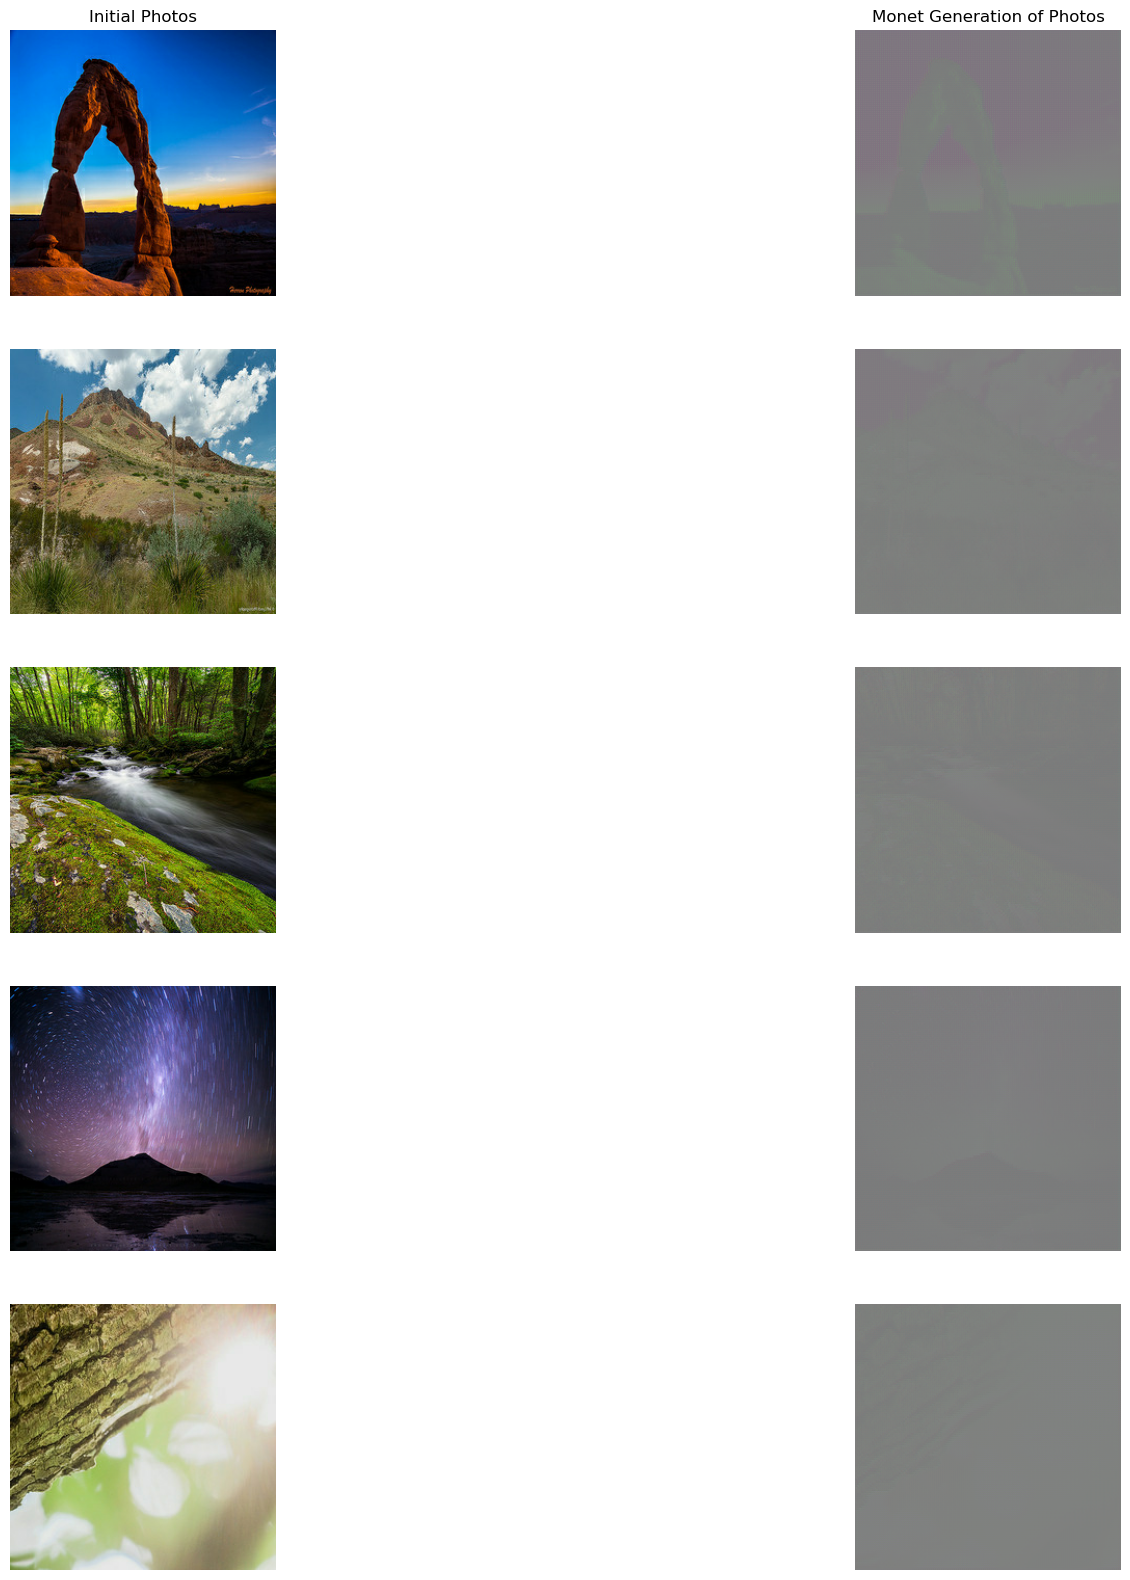

In [189]:
#Visualizing the model's monet of photos
fig, ax = plt.subplots(5, 2, figsize=(20,20))
ax[0, 0].set_title('Initial Photos')
ax[0, 1].set_title('Monet Generation of Photos')
for i, img in enumerate(photo_dataset.take(5)):
    predict = generate_monet(img, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(predict)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.show()

## Second Iteration of Model

After the initial iteration of my model, I wanted to tune my hyperparameters and check performance. This was done by adding more filters to the generator and the discriminator. Additionally, in the decoder function, I lowered the dropout rate when it was called in the function. Thus, the model should get higher performance, with slower speed. Further, I added 20 epochs in the same vein, which would take longer to model, but should result in better performance.

In [190]:
##Second model with improved hyperparameters

#generator for the data which utilizes encoders and decoders
def Generator():
    #input layer which has images of size (256, 256, 3) due to rgb
    inputs = Input(shape=[256, 256, 3])
    #encoding the input layer by calling encoder function set times with #filters and size
    encoders = [
        encoder(64, 4, apply_batchnorm=False),
        encoder(256, 4),
        encoder(256, 4),
        encoder(256, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4)
    ]
    #decoding the output from the encoders calling decoder function with #filters and size
    decoders = [
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(256, 4),
        decoder(256, 4),
        decoder(128, 4),
        decoder(64, 4)
    ]
    initializer = tf.random_normal_initializer(0, 0.02)
    #final layer of decoder which adds conv2d with 3 fitlers and tanh to get back to proper channels
    ##we see we have same number of encoder layers as decoder layers
    final = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer=initializer,
                          activation = 'tanh')
    #taking each input and running it through each encoder instances
    vals = inputs
    skips = []
    for down in encoders:
        vals = down(vals)
        skips.append(vals)
    #reversing and going through decoders
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoders, skips):
        vals = up(vals)
        vals = Concatenate()([vals, skip])
    vals = final(vals)
    #thus, runs through eno
    return tf.keras.Model(inputs=inputs, outputs=vals)

In [191]:
def decoder(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding conv2d transpose layer (opposite of last conv) to decode back to normal
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())
    #adding dropout layers for certain layers when provided to improve model performance
    if apply_dropout:
        model.add(Dropout(0.4))
    model.add(ReLU())
    return model

In [192]:
#setting generator and discriminator for monet and photo
#applying generator and discriminators for each photo and monet
generate_monet = Generator()
generate_photo = Generator()
discriminate_monet = Discriminator()
discriminate_photo = Discriminator()

#using adam as optimizer with learning rate 0.0002 and beta of 0.5
#utilizing legacy version of Adam as due to my tf version, legacy optimizer is needed to run
adam = tf.keras.optimizers.legacy.Adam(0.0002, beta_1=0.5)
#setting optimizers for each generation and discrimination of monet and photo
generate_monet_opt = adam
generate_photo_opt = adam
discriminate_monet_opt = adam
discriminate_photo_opt = adam

In [193]:
#creating our CycleGan and providing generators and discriminators
cycle_gan = CycleGan(
    generate_monet, generate_photo, discriminate_monet, discriminate_photo
)
#compiling gan with optimizers and loss functions
cycle_gan.compile(
    generate_monet_opt,
    generate_photo_opt,
    discriminate_monet_opt,
    discriminate_photo_opt,
    generator_loss,
    discriminator_loss,
    cycle_loss,
    identity_loss
)


#fitting model on both datasets and going through 10 epochs here
cycle_gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=20
)

Epoch 1/20


2023-03-05 23:28:47.353250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 150s 451ms/step - generator_monet_loss: 4.7205 - generator_photo_loss: 4.7440 - discriminator_monet_loss: 0.7011 - discriminator_photo_loss: 0.7045
Epoch 2/20
300/300 [==============================] - 126s 420ms/step - generator_monet_loss: 3.5116 - generator_photo_loss: 3.5277 - discriminator_monet_loss: 0.6588 - discriminator_photo_loss: 0.6612
Epoch 3/20
300/300 [==============================] - 143s 477ms/step - generator_monet_loss: 3.2521 - generator_photo_loss: 3.2822 - discriminator_monet_loss: 0.6505 - discriminator_photo_loss: 0.6540
Epoch 4/20
300/300 [==============================] - 148s 493ms/step - generator_monet_loss: 3.0607 - generator_photo_loss: 3.0982 - discriminator_monet_loss: 0.6441 - discriminator_photo_loss: 0.6470
Epoch 5/20
300/300 [==============================] - 148s 492ms/step - generator_monet_loss: 2.9330 - generator_photo_loss: 2.9697 - discriminator_monet_loss: 0.6403 - discriminator_photo_loss: 0.6430
E

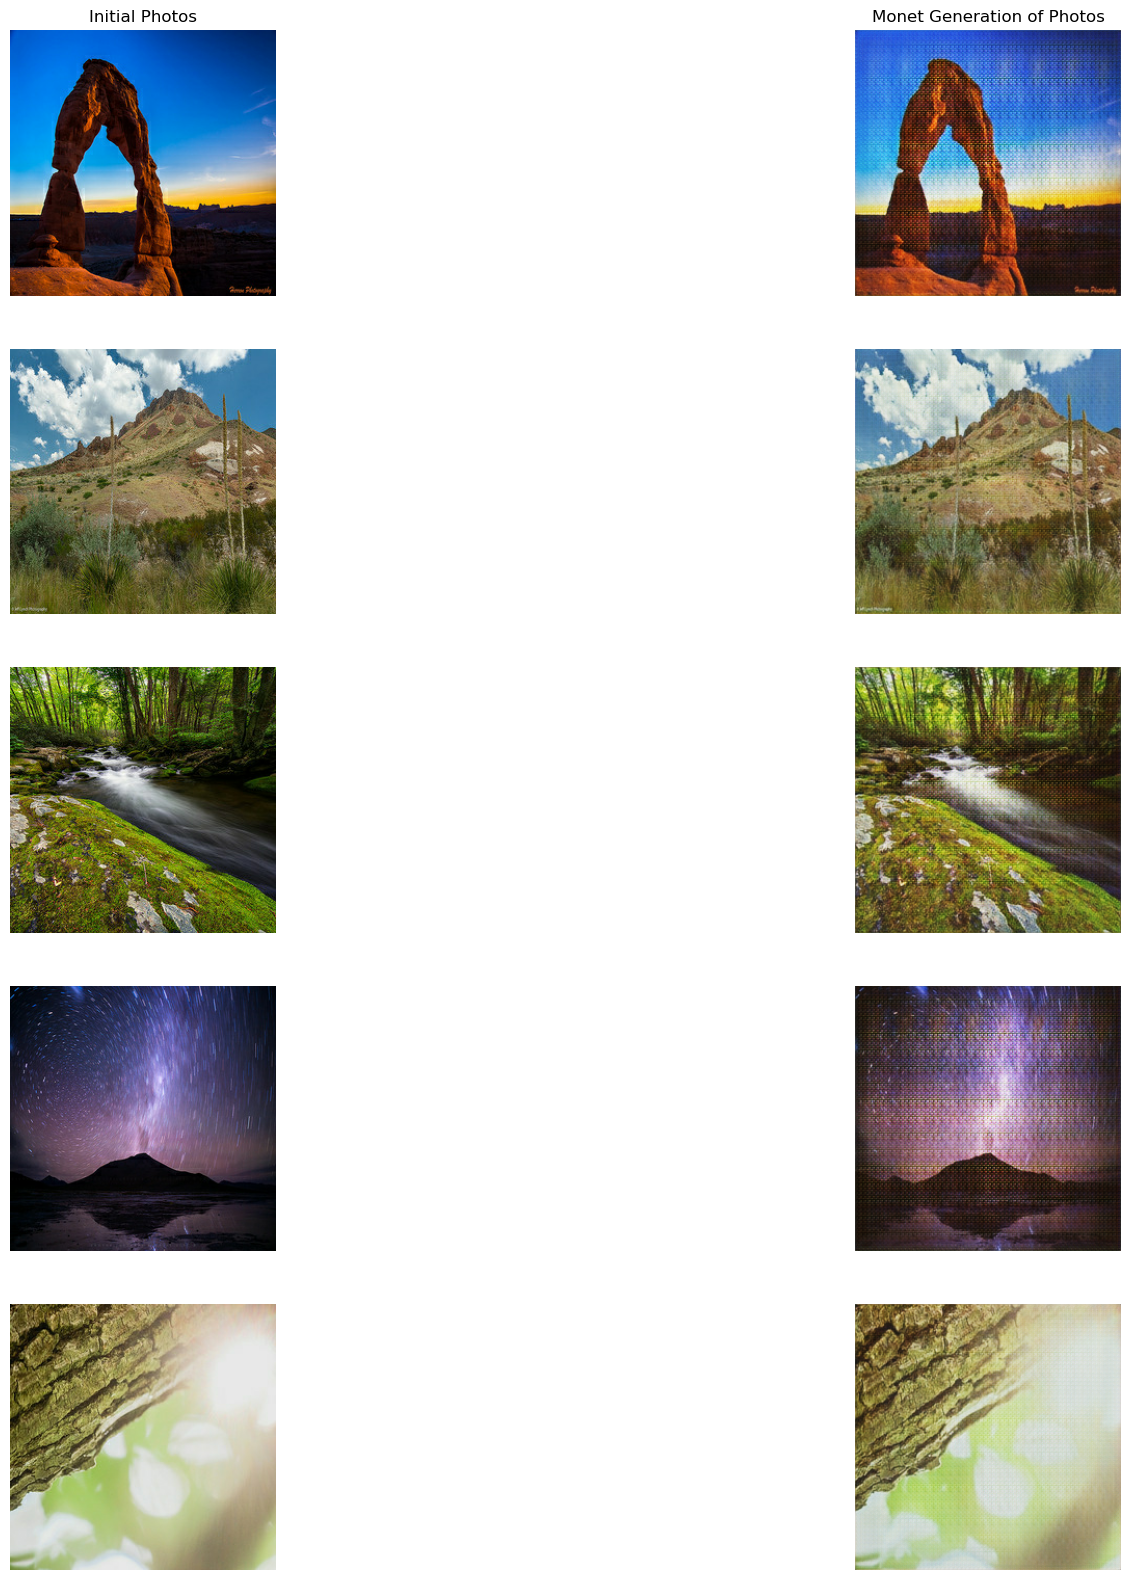

In [196]:
#Visualizing the model's monet of photos
fig, ax = plt.subplots(5, 2, figsize=(20,20))
ax[0, 0].set_title('Initial Photos')
ax[0, 1].set_title('Monet Generation of Photos')
for i, img in enumerate(photo_dataset.take(5)):
    predict = generate_monet(img, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(predict)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.show()

## Prediction 

This competition was unlike others of this course as we had to create a zip of the images in a Kaggle notebook. Here, we create a images.zip folder and we write the generated photo in style of Monet in each zip. These were saved as 'jpgs'. My work for this was based off https://www.kaggle.com/code/zahid0/gan-tensorflow as I struggled to output the data in my Kaggle notebook.

In [197]:
#submitting predictions

from io import BytesIO
from PIL import Image
from zipfile import ZipFile

with ZipFile('images.zip', mode='w') as zip_f:
    val = 1
    for img in photo_dataset:
        predict = generate_monet(img, training=False)[0].numpy()
        predict = (predict * 127.5 + 127.5).astype(np.uint8)
        with BytesIO() as image_byte:
            Image.fromarray(predict).save(image_byte, 'JPEG')
            image_byte.seek(0)
            zip_f.writestr('{}.jpg'.format(val), image_byte.read())
            val += 1

## Conclusion 

This was my first ever GAN and it was quite a steep learning curve for me, particularly as it has a different structure than other models of this course or which I've used before. However, the GAN here was utilized to generate photos in the style of Monet from provided photos. This occurs by generating photos and seeking for them to beat a discriminator which will look at photos and the generated photos. Hence, the adversarial nature of the GAN. This project provided photos and Monet paintings and our model utilized these as inputs. Our initial model with its hyperparameters received a score of 684 on the Kaggle competition. I decided to apply one more iteration of the model and will run it through the Kaggle notebook. This did not increase my score at all; however, it took approximately 40 minutes to run longer. Given, the nature of this project, I did not have time to proceed further in hyperparameter tuning.

I must say the sources below were invaluable to me given my inexperience with this modeling type. I largely followed the outline provided by the notebook provided by Kaggle as well as the GAN instances found in the Tensorflow examples below.

## Sources: 

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

https://www.tensorflow.org/tutorials/load_data/tfrecord

https://www.tensorflow.org/tutorials/generative/cyclegan

https://www.kaggle.com/code/zahid0/gan-tensorflow

https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

https://keras.io/examples/generative/cyclegan/

https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564